<a href="https://colab.research.google.com/github/CleberYoo/AI_Drills_2023ver/blob/main/Canny_Edge_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

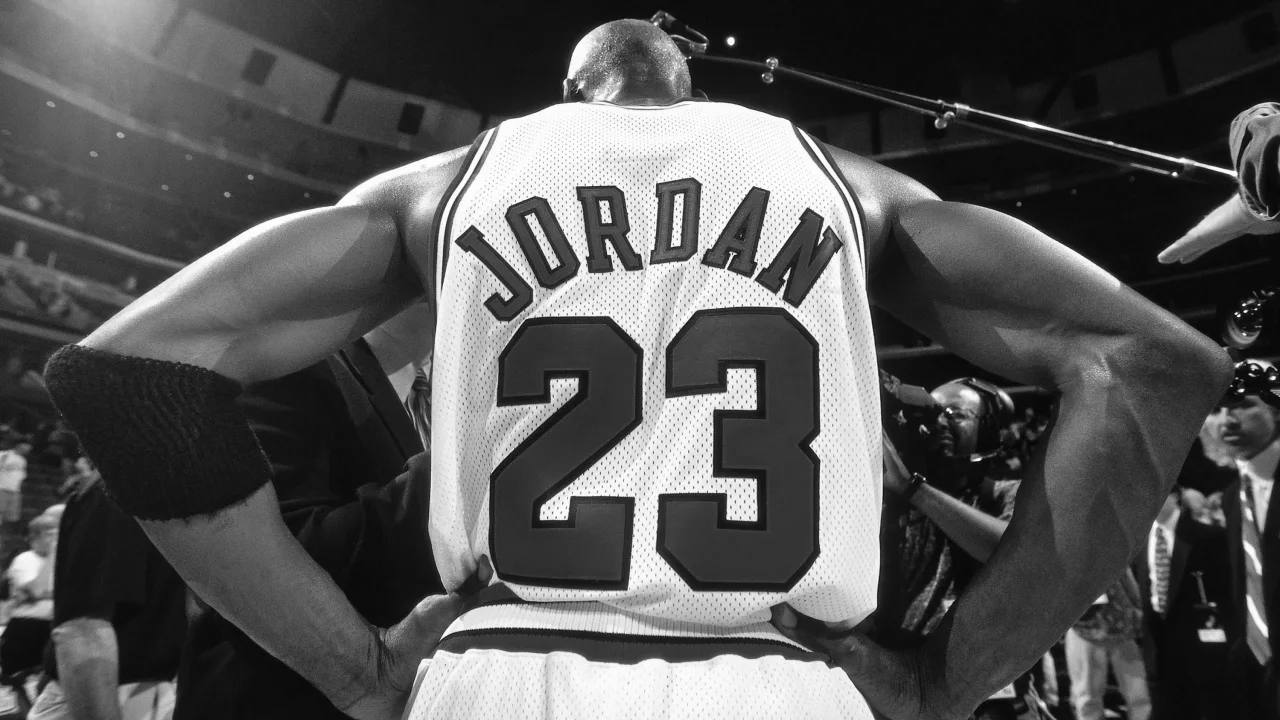

In [ ]:
image_MJ = cv2.imread('/content/210616193554-01-michael-jordan-athlete-activism.jpg.webp', 0)
cv2_imshow(image_MJ)

In [ ]:
np.arange(-5, 5)

array([-5, -4, -3, -2, -1,  0,  1,  2,  3,  4])

In [ ]:
array = np.arange((11//2)*(-1), (11//2)+1)
print(array)

[-5 -4 -3 -2 -1  0  1  2  3  4  5]


# 가우시안 필터링

In [ ]:
# size : 커널 크기       sigma : 표준편차 (sigma^2 : 분산)
def Gaussian(size, sigma):
    #중심에서부터의 거리 계산
    array = np.arange((size//2)*(-1), (size//2)+1)

    #x^2+y^2 배열 초기화
    xx_yy_array = np.zeros((size, size))

    for x in range(size):
        for y in range(size):
            #중심에서부터의 거리를 제곱합으로 계산
            xx_yy_array[x,y] = array[x]**2+array[y]**2

    # 필터 초기화
    filter = np.zeros((size, size))

    for x in range(size):
        for y in range(size):
             # 수학적 수식 구현부
             filter[x,y] = 1 / (2 * np.pi * sigma**2) * np.exp(-xx_yy_array[x,y]/(2 * sigma**2))

    # Scaling
    filter /= filter.sum()

    return filter

In [ ]:
# 표준편차 : 1 & 5X5 크기의 가우시안 필터 객체 생성
gaussian_3X3 = Gaussian(3, 1)

In [ ]:
# 컨볼루션
gaussian_MJ = cv2.filter2D(image_MJ, -1, gaussian_3X3)

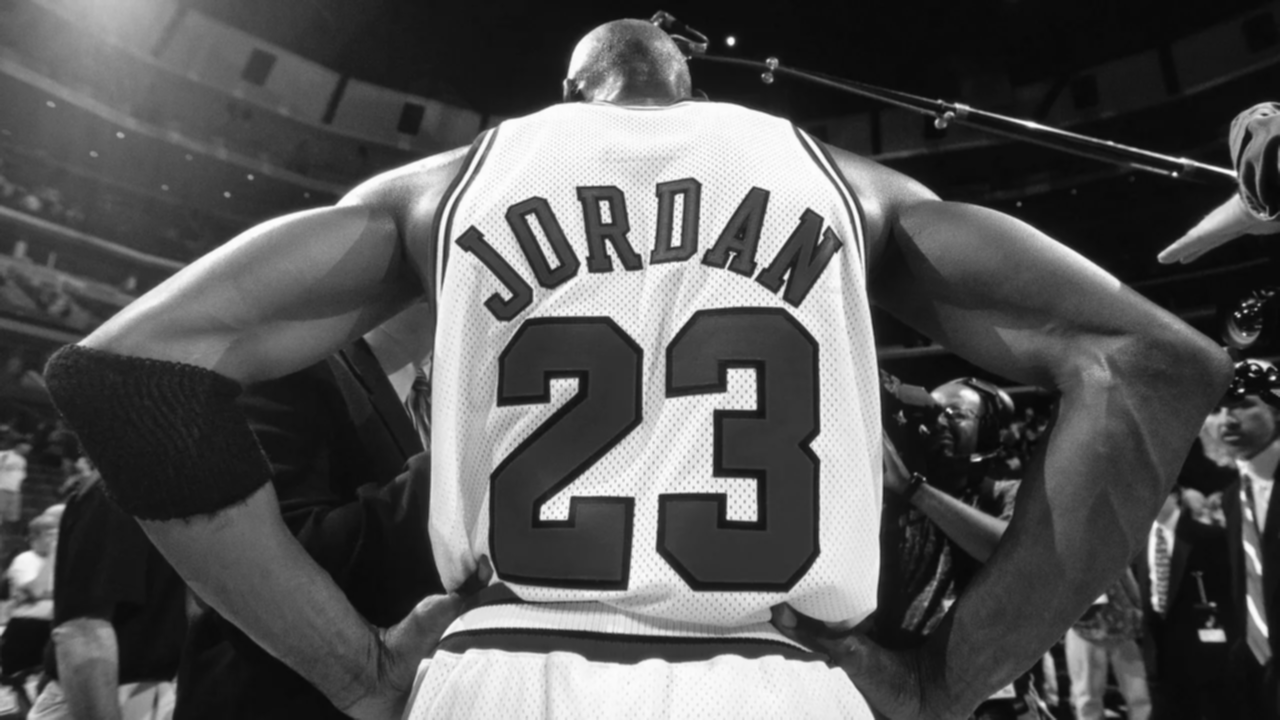

True

In [ ]:
cv2_imshow(gaussian_MJ)
cv2.imwrite('/content/gaussian_MJ.png', gaussian_MJ)

# gradient 계산

In [ ]:
# gradient를 구하는 방법
# 소벨 필터
def sobel(image):
    #x,y 필터
    sobel_vertical = np.array([[-1, 0, 1],
                               [-2, 0, 2],
                               [-1, 0, 1]])
    sobel_horizontal = np.array([[-1,-2,-1],
                                 [ 0, 0, 0],
                                 [ 1, 2, 1]])

    # x축, y축에 대해 콘볼루션
    gradient_x = cv2.filter2D(image, -1, sobel_vertical)
    gradient_y = cv2.filter2D(image, -1, sobel_horizontal)

    # 유클리디안 거리 구하기
    # == np.sqrt(gradient_x **2 + gradient_y ** 2)
    gradient = np.hypot(gradient_x, gradient_y)
    # Normalization
    gradient = gradient / gradient.max() * 255

    theta = np.arctan2(gradient_y, gradient_x)

    return (gradient, theta)

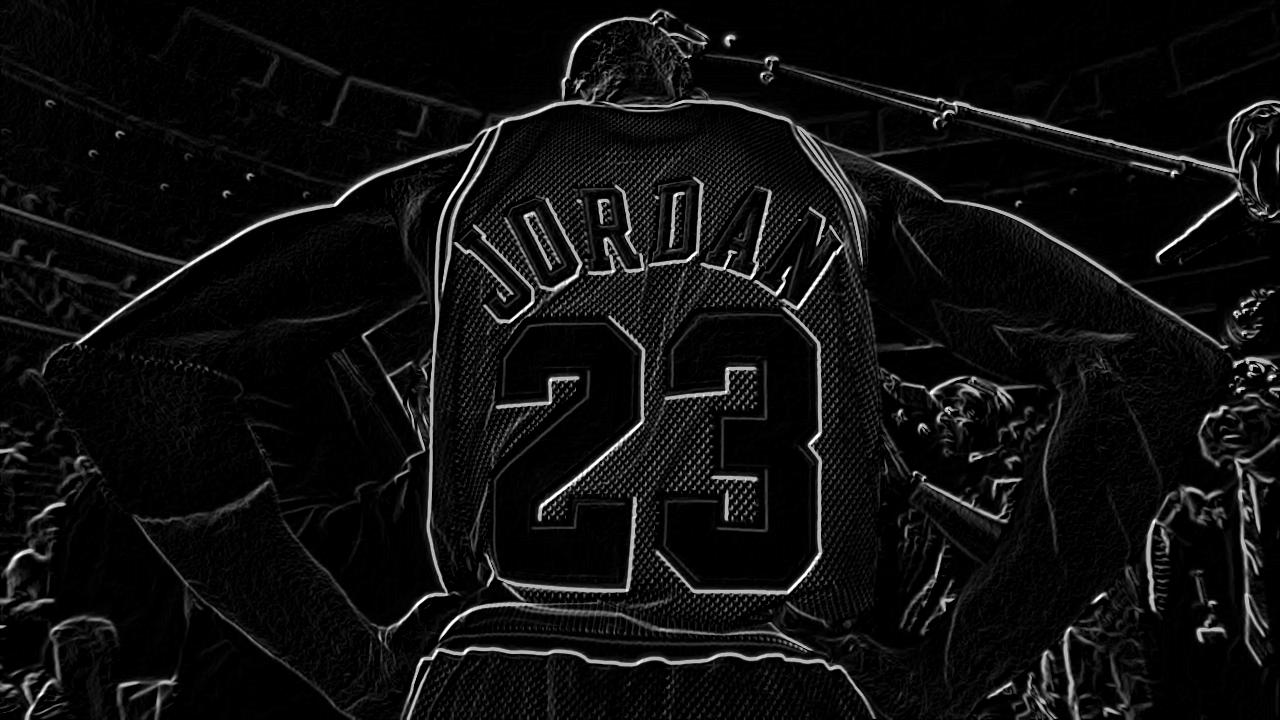

In [ ]:
gradient_MJ, theta = sobel(gaussian_MJ)
cv2_imshow(gradient_MJ)
#cv2.imwrite('/content/gradient_MJ.png', gradient_MJ)

# Non-Maximum Suppression

![](https://i0.wp.com/theailearner.com/wp-content/uploads/2019/05/Grad_direc-2.png?w=713&ssl=1)

In [ ]:
def non_max_suppression(gradient, theta):

    height, width = gradient.shape
    # 결과를 저장할 리스트 선언
    result = np.zeros((height, width))
    # 방향성분
    angle = theta * 180. / np.pi
    angle[angle < 0] += 180

    #(0,45,90,135) 방향을 돌면서 연산
    for i in range(1, height-1):
        for j in range(1, width-1):
            # 0 degrees ( & 180 degree)
            if (0 <= angle[i, j] < 22.5) or (157.5 <= angle[i, j] <= 180):
                left = gradient[i, j - 1]
                right = gradient[i, j + 1]

            # 45 degrees ( & 225 degree)
            elif 22.5 <= angle[i, j] < 67.5:
                left = gradient[i - 1, j + 1]
                right = gradient[i + 1, j - 1]

            # 90 degrees ( & 270 degree)
            elif 67.5 <= angle[i, j] < 112.5:
                left = gradient[i - 1, j]
                right = gradient[i + 1, j]

            # 135 degrees ( & 315 degree)
            elif 112.5 <= angle[i, j] < 157.5:
                left = gradient[i - 1, j - 1]
                right = gradient[i + 1, j + 1]

            if (gradient[i, j] > left) and (gradient[i, j] > right):
                result[i, j] = gradient[i, j]
            else:
                result[i, j] = result[i, j]
    return result

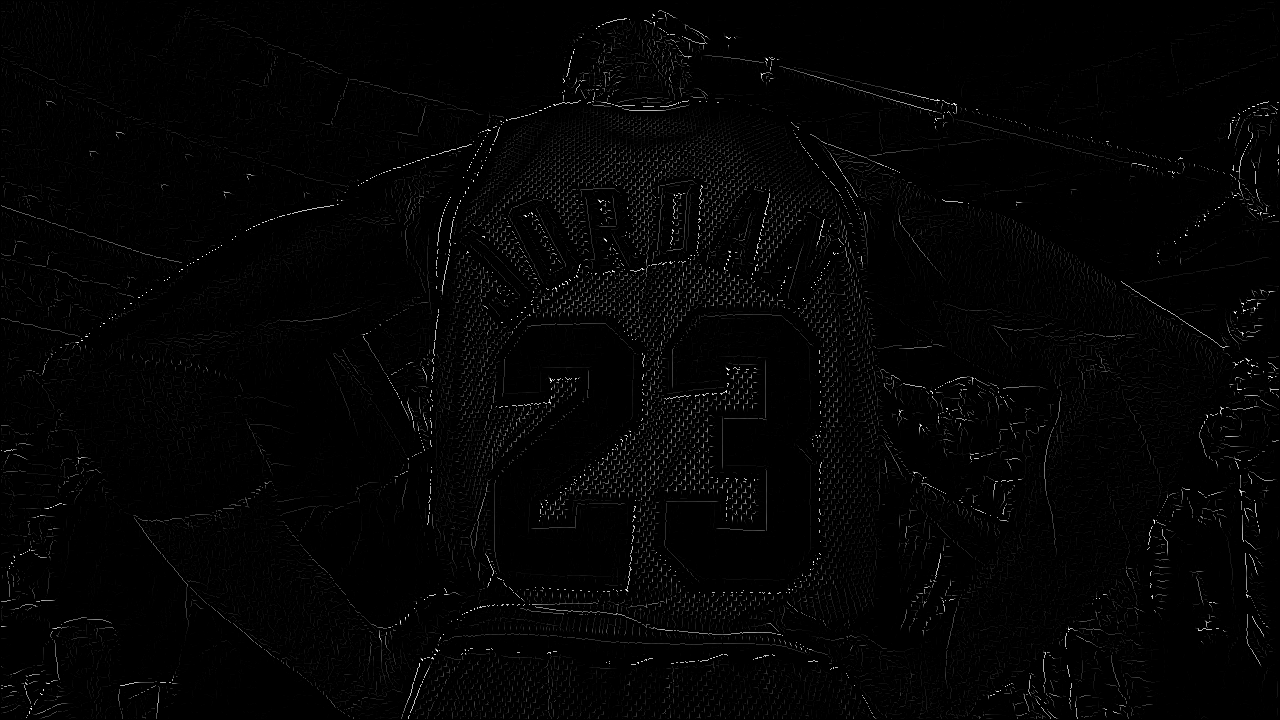

True

In [ ]:
NMS_MJ = non_max_suppression(gradient_MJ, theta)

cv2_imshow(NMS_MJ)
cv2.imwrite('/content/NMS_MJ.png', NMS_MJ)

In [ ]:
def threshold(image):

    high_threshold = 64
    low_threshold = 32

    result = np.zeros(image.shape, dtype=np.int32)

    # strong, weak 설정
    strong_pixel_value = 255
    weak_pixel_value = 96

    # strong edge, weak edge 계산
    strong_x, strong_y = np.where(image > high_threshold)
    weak_x, weak_y = np.where((image <= high_threshold) & (image >= low_threshold))

    result[strong_x, strong_y] = strong_pixel_value
    result[weak_x, weak_y] = weak_pixel_value

    return result

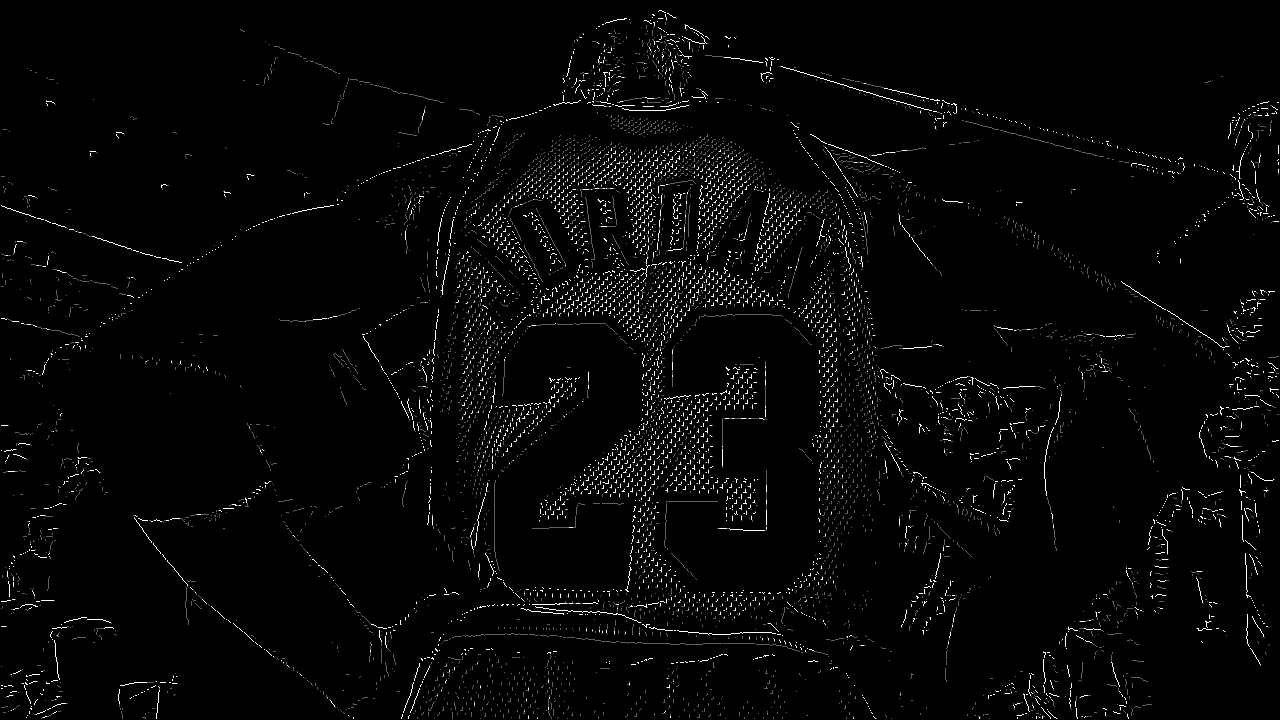

In [ ]:
threshold_MJ = threshold(NMS_MJ)

cv2_imshow(threshold_MJ)

In [ ]:
def hysteresis(image):
    height, width = image.shape
    weak = 96
    strong = 255

    # strong edge, weak edge 판별
    for i in range(1, height-1):
        for j in range(1, width-1):
            if(image[i,j] == weak):
                if ((image[i + 1, j - 1] == strong) or (image[i + 1, j] == strong) or (image[i + 1, j + 1] == strong)
                        or (image[i, j - 1] == strong) or (image[i, j + 1] == strong)
                        or (image[i - 1, j - 1] == strong) or (image[i - 1, j] == strong) or (image[i - 1, j + 1] == strong)):
                    image[i, j] = strong
                else:
                    image[i, j] = 0
    return image

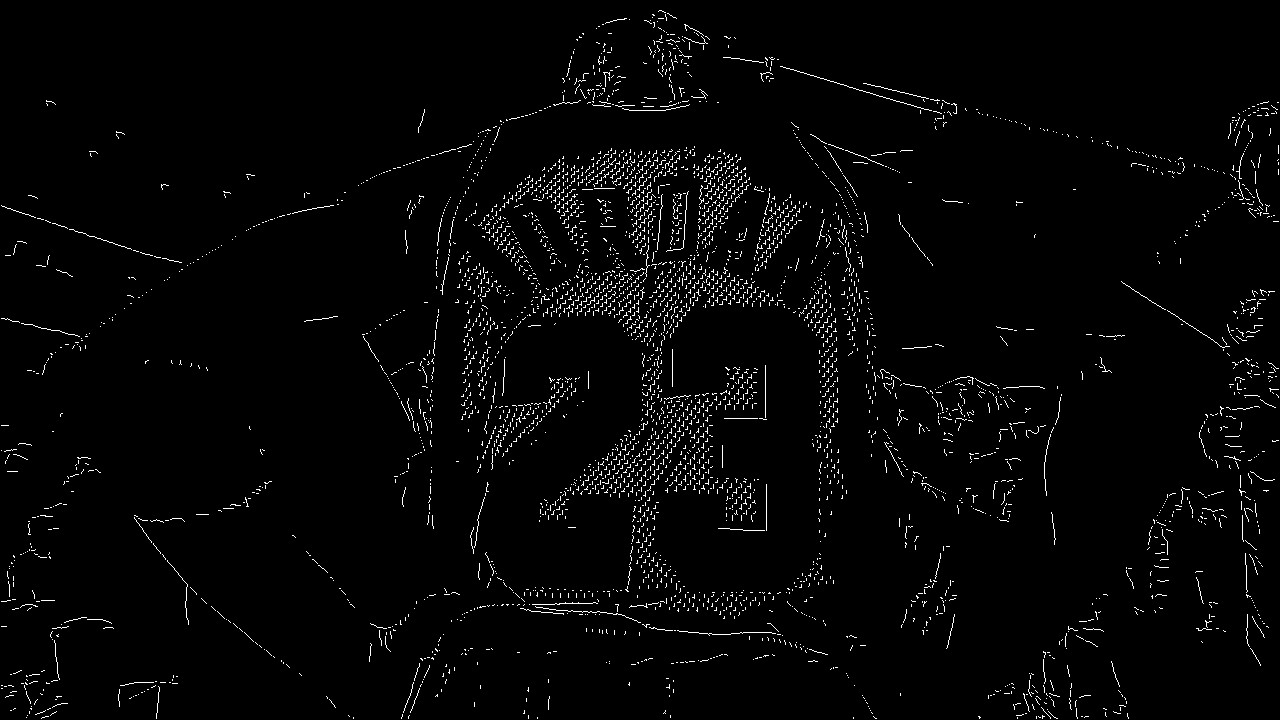

True

In [ ]:
hysteresis_MJ = hysteresis(threshold_MJ)

cv2_imshow(hysteresis_MJ)
cv2.imwrite('/content/hysteresis_MJ.png', hysteresis_MJ)

In [ ]:
image_MJ.max()

255

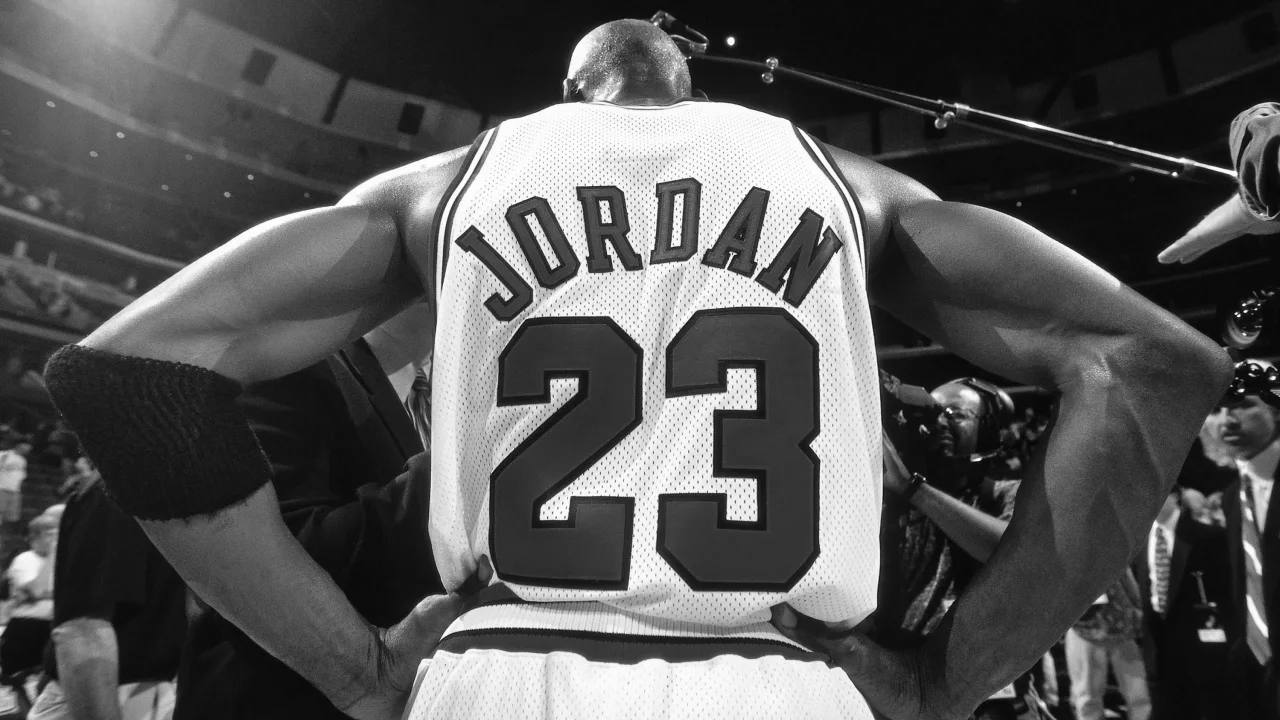

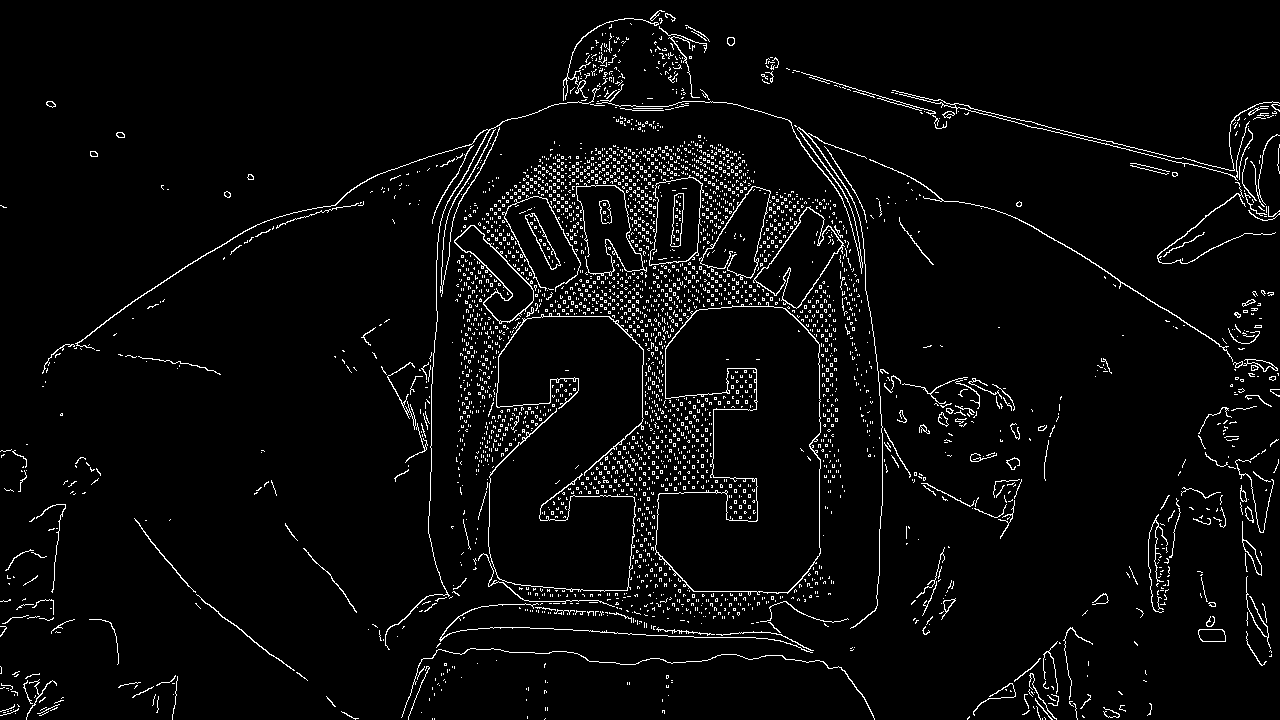

In [ ]:
canny2 = cv2.Canny(image_MJ, 192, 224)    # OpenCV 캐니 에지

cv2_imshow(image_MJ)
#cv2.imwrite('/content/MJ.png', image_board)

cv2_imshow(canny2)
#cv2.imwrite('/content/MJ_after_canny.png', canny2)